In [1]:
import os
from termcolor import colored
from tqdm import tqdm
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

import re
import emoji
from nlp_id import Lemmatizer, StopWord
import string

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
import keras.backend as K

from transformers import TFBertModel
from transformers import AutoTokenizer

import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

RUN_OPTIONAL_CELLS = True

In [2]:
def get_path(path:str):
  '''
  Dynamic Path Finding for cloud and local computing
  '''
  CLOUD_PATH = '/content/drive/MyDrive/Cloud Computing Data/datathon_2022/'
  if IN_COLAB:
    return (CLOUD_PATH+path).replace('//', '/')
  return path
    

In [3]:
train = pd.read_csv(get_path('data/train.csv'), parse_dates=['created_at'])
test = pd.read_csv(get_path('data/test.csv'), parse_dates=['created_at'])
target = pd.DataFrame({'label': train['label'].values})
DROP = ['url', 'user_id']

# Image Data

In [4]:
IMG_SHAPE = (260, 260, 3)
IMG_SOURCE = ['external', 'native'] # native, external, external_2

In [5]:
def _load_img(file_path:str):
    """
        convert file_path to numpy array image with shape: globals()['IMG_SHAPE']
        param:
            file_path: .csv or folder path of a image
    """
    if file_path.endswith('.csv'):
        data = pd.read_csv(file_path)
        img_arr = None
        for inx, row in tqdm(data.iterrows(), total=len(data)):
            nw_img_path = row['media']
            if img_arr is None:
                img_arr = cv2.resize(cv2.cvtColor(cv2.imread(f'{get_path("data/media/"+nw_img_path)}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)
            else:
                img_arr = np.vstack([img_arr, cv2.resize(cv2.cvtColor(cv2.imread(f'{get_path("data/media/"+nw_img_path)}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)])
        return img_arr
    else:
        img_arr = None
        for current_file in os.listdir(file_path):
            if not current_file.endswith('.jpg'):
                continue
            nw_img_path = os.path.join(file_path, current_file)
            if img_arr is None:
                img_arr = cv2.resize(cv2.cvtColor(cv2.imread(f'{get_path("data/media/"+nw_img_path)}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)
            else:
                img_arr = np.vstack([img_arr, cv2.resize(cv2.cvtColor(cv2.imread(f'{get_path("data/media/"+nw_img_path)}'), cv2.COLOR_RGB2BGR), IMG_SHAPE[:-1]).reshape(1, *IMG_SHAPE)])
        return img_arr

## Internal Data

## Tabular

In [6]:
def get_date_feature(df:pd.DataFrame, col:str) -> pd.DataFrame:
    df['year'] = df[col].dt.year
    df['month'] = df[col].dt.month
    df['week'] = np.int32(df[col].dt.isocalendar().week)
    df['weekday'] = df[col].dt.weekday
    df['quarter'] = df[col].dt.quarter
    df['day_of_year'] = df[col].dt.day_of_year
    df['day'] = df[col].dt.day
    df['day_of_week'] = df[col].dt.day_of_week
    return df

## Image

In [7]:
def get_image_dataset() -> tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """
        get original image dataset
        return:
            train_img
            test_img
            target
    """
    target = pd.read_csv(get_path(f'checkpoints/img_arr_(600, 600, 3)_target.csv'))
    file_name = get_path(f'checkpoints/img_arr_{IMG_SHAPE}')
    if os.path.exists(file_name+'.npy'):
        train_img = np.load(file_name+'.npy')
    else:
        train_img = _load_img(get_path('data/train.csv'))
        np.save(file_name, train_img)
    
    test_name = get_path(f'checkpoints/test_img_arr_{IMG_SHAPE}')
    if os.path.exists(test_name+'.npy'):
        test_img = np.load(test_name+'.npy')
    else:
        test_img = _load_img(get_path('data/test.csv'))
        np.save(test_name, test_img)
    return train_img, test_img, target

def get_oversampled_train_image_dataset(test_split_ratio:float = 0.2) -> tuple[np.ndarray, pd.DataFrame]:
    """
        return oversampled training data with validation split that avoid data leakage
        return
            train_x, val_x, train_y, val_y
    """
    train_img, test_img, target = get_image_dataset()

    train_x, val_x, train_y, val_y = train_test_split(train_img, target, test_size=test_split_ratio)
    
    pos_features = train_x[train_y['label'] == 1]
    neg_features = train_x[~(train_y['label'] == 1)]

    pos_labels = train_y[train_y['label'] == 1]
    neg_labels = train_y[train_y['label'] == 0]

    assert len(pos_features)+len(neg_features) == len(pos_labels)+len(neg_labels)

    nw_features = pos_features[:]
    nw_labels = pos_labels.copy(deep=True)

    train_img = np.concatenate([pos_features, neg_features, nw_features, nw_features])
    target = pd.concat([pos_labels, neg_labels, nw_labels, nw_labels], axis=0)
    assert len(train_img) == len(target)
    return train_img, val_x, target, val_y

## Text

In [8]:
MAX_WORD = 50

### Tokenization

In [9]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

regex_str = []
regex_str.append(emoticons_str)
regex_str.append(r'<[^>]+>') # HTML tags
regex_str.append(r'(?:@[\w_]+)') # @-mentions
regex_str.append(r'(?:&[\w_]+)')
regex_str.append(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)") # hash-tags
regex_str.append(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+') # URLs
regex_str.append(r'(?:(?:\d+,?)+(?:\.?\d+)?)') # numbers
regex_str.append(r"(?:[a-z][a-z'\-_]+[a-z])") # words with - and '
regex_str.append(r'(?:[\w_]+)') # other words
regex_str.append(r'(?:\S)') # anything else

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def tokenize(sentence):
    return [emoji.demojize(term) for term in tokens_re.findall(sentence)]

### Stopwords and Lemmatisation

In [10]:
lemmatizer = Lemmatizer()
stopword = StopWord()

punctuation = list(string.punctuation)
stops = stopword.get_stopword() + punctuation + ['rt', 'via', '…','•','“']

def stopwords_and_lemmatize(tokenized_sentence):
  processed_words = []
  for word in tokenized_sentence:
    if word.lower() not in stops:
      processed_words.append(lemmatizer.lemmatize(word))
  return processed_words

### Final Pipeline

In [11]:
def preprocess_text(sentence):
    return stopwords_and_lemmatize(tokenize(sentence))

In [12]:
def get_vtext_dataset() -> tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    raise NotImplementedError
    """
        get original text dataset
        return:
            train_vtext
            test_vtext
            target
    """
    from gensim.models.fasttext import load_facebook_model
    ft = load_facebook_model('pretrained/fastText/cc.id.300.bin')

    target = pd.read_csv(get_path(f'checkpoints/img_arr_(600, 600, 3)_target.csv'))
    file_name = get_path(f'checkpoints/text_vtext_{IMG_SHAPE}')
    if os.path.exists(file_name+'.npy'):
        train_text = np.load(file_name+'.npy')
    else:
        train_text = None
        for inx, row in train.iterrows():
            # Continue
            if train_text is None:
                train_text = np.array(preprocess_text(row['text']))
            else:
                pass
            np.save(file_name, img_arr)
    
    test_name = get_path(f'checkpoints/test_img_arr_{IMG_SHAPE}')
    if os.path.exists(test_name+'.npy'):
        test_img_arr = np.load(test_name+'.npy')
    else:
        test_img_arr = _load_img(get_path('data/test.csv'))
        np.save(test_name, test_img_arr)
    return img_arr, test_img_arr, target

def get_text_dataset() -> tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    return train['text'].copy(), test['text'].copy(), target.copy()

## External Data

In [13]:
pass
if 'external' in IMG_SOURCE:
    pass

# Metrics and Template

In [14]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * (precision * recall) / (precision+recall + K.epsilon())

# Modelling

In [15]:
import tensorflow as tf
import keras
from keras import layers, activations, losses, optimizers, initializers, regularizers, metrics, Input, models
import sklearn.metrics as skMetrics
from sklearn.model_selection import train_test_split

def plot_hist(hist):
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.plot(hist.history['acc'], label = 'train')
    plt.plot(hist.history['val_acc'], label = 'validation')
    plt.xlabel('acc')
    plt.legend()
    fig.add_subplot(1, 2, 2)
    plt.plot(hist.history['mae'], label = 'train')
    plt.plot(hist.history['val_mae'], label = 'validation')
    plt.xlabel('mae')
    plt.legend()

## EfficientNetB

In [16]:
# from sklearn.model_selection import train_test_split

# img_arr, test_img_arr, target = get_image_dataset()

# train_x, val_x, train_y, val_y = train_test_split(img_arr, target, test_size=0.2, stratify=target)

In [17]:
# from keras.applications import EfficientNetB4
# from keras.applications.efficientnet import preprocess_input

# input_layer = Input(shape=IMG_SHAPE, dtype=tf.float32)
# efficientNetB7_layer = EfficientNetB4()(preprocess_input(input_layer))
# efficientNetB7_layer.trainable = False
# flatten_layer = layers.Flatten()(efficientNetB7_layer)
# dense_layer = layers.Dense(400, activation='relu')(flatten_layer)
# dropout_layer = layers.Dropout(.2)(dense_layer)
# dense_layer = layers.Dense(200, activation='relu')(flatten_layer)
# dropout_layer = layers.Dropout(.2)(dense_layer)
# output_layer = layers.Dense(1, activation='sigmoid')(dropout_layer)

# model = keras.Model(inputs=input_layer, outputs=output_layer)

# model.compile('adam', loss=losses.BinaryCrossentropy(), metrics=['mae', 'acc'])

In [18]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=7, restore_best_weights=True)
# hist = model.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=64, epochs=20, callbacks=[callback])

In [19]:
# model.save(get_path('model2_150neuron.h5'))

## Full Complex Model

### Data Analyst

Maksimal kata pada variabel text : 56


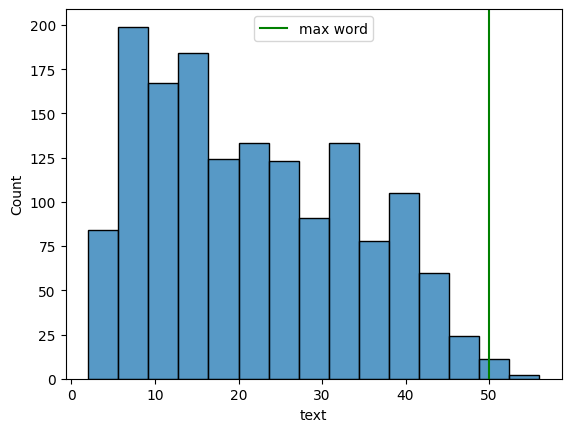

In [20]:
if RUN_OPTIONAL_CELLS:
    sns.histplot(train['text'].map(lambda x: len(x.split())))
    plt.axvline(MAX_WORD, color='green', label='max word')
    plt.legend()
    print(f'Maksimal kata pada variabel text :', colored(train['text'].map(lambda x: len(x.split())).max(), 'green'))

### Data Preparation

#### Plot Pos-Neg Words

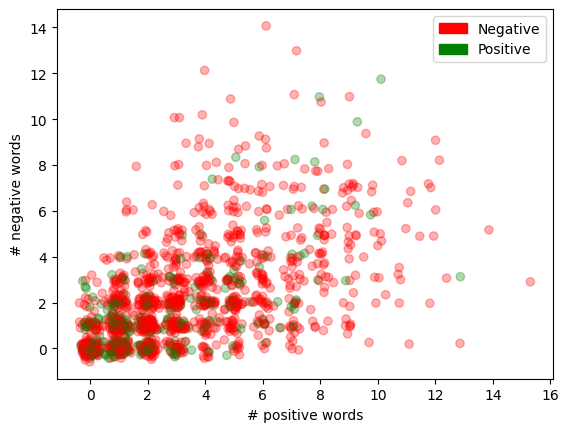

In [21]:
# sentword_score = {}

# def load_sentword(filename):
#   file = open(filename, "r")
#   file.readline()
#   for line in file:
#     word, score = line.strip().split("\t")
#     score = int(score)
#     sentword_score[word] = score
#   file.close()

# load_sentword("tools/negative.tsv")
# load_sentword("tools/positive.tsv")

# import matplotlib.patches as mpatches

# num_pos = []
# num_neg = []
# scores  = []

# for _, row in train.iterrows():
#   tokens = tokenize(row["text"])
#   label = row[target.columns[0]]
#   num_negative, num_positive = 0, 0

#   for token in tokens:
#     if token in sentword_score:
#       if (sentword_score[token] < 0):
#         num_negative += 1
#       elif (sentword_score[token] > 0):
#         num_positive += 1
#   num_pos.append(num_positive)
#   num_neg.append(num_negative)
#   scores.append(label)

# # tambahkan kolom di dataframe
# train["pos_words"] = num_pos
# train["neg_words"] = num_neg

# # add jitters
# num_pos = np.array(num_pos)
# num_neg = np.array(num_neg)
# num_pos = num_pos + np.random.normal(0, 0.2, len(num_pos))
# num_neg = num_neg + np.random.normal(0, 0.2, len(num_neg))

# if RUN_OPTIONAL_CELLS:
#   colors = ['g' if score == 1 else 'r' for score in scores]
#   plt.scatter(num_pos, num_neg, c = colors, alpha=0.3)
#   plt.xlabel('# positive words')
#   plt.ylabel('# negative words')

#   # Legend
#   red_patch = mpatches.Patch(color='red', label='Negative')
#   green_patch = mpatches.Patch(color='green', label='Positive')

#   plt.legend(handles=[red_patch, green_patch])
#   plt.show()

#### Tabular Data

In [22]:
train.columns

Index(['created_at', 'id', 'user_id', 'user_name', 'url', 'text', 'media',
       'label', 'pos_words', 'neg_words'],
      dtype='object')

In [23]:
def get_positive_negative_word(df, is_train):
    def load_sentword(filename):
        file = open(filename, "r")
        file.readline()
        for line in file:
            word, score = line.strip().split("\t")
            score = int(score)
            sentword_score[word] = score
        file.close()

    load_sentword(get_path("tools/negative.tsv"))
    load_sentword(get_path("tools/positive.tsv"))

    num_pos = []
    num_neg = []
    tot_pos = []
    tot_neg = []

    if is_train:
        temp = train
    else:
        temp = test

    for _, row in temp.iterrows():
        tokens = tokenize(row["text"])
        num_negative, num_positive, total_positive, total_negative = 0, 0, 0, 0

        for token in tokens:
            if token in sentword_score:
                if (sentword_score[token] < 0):
                    total_negative += sentword_score[token]
                    num_negative += 1
                    
                elif (sentword_score[token] > 0):
                    total_positive += sentword_score[token]
                    num_positive += 1
        num_pos.append(num_positive)
        num_neg.append(num_negative)
        tot_pos.append(total_positive)
        tot_neg.append(total_negative)

    # tambahkan kolom di dataframe
    df["pos_words"] = num_pos
    df["neg_words"] = num_neg
    df["sum_pos_words"] = tot_pos
    df["sum_neg_words"] = tot_neg
    return df

def get_tabular_dataset() -> tuple[pd.DataFrame, pd.DataFrame]:
    """
        return:
            train
            test
            target
    """
    tabular_train = train.copy()
    tabular_test = test.copy()

    tabular_train = get_date_feature(tabular_train, 'created_at')
    tabular_test = get_date_feature(tabular_test, 'created_at')

    tabular_train = tabular_train.drop(['created_at', 'id', 'user_id', 'user_name', 'url', 'text', 'media', 'label'], axis=1)
    tabular_test = tabular_test.drop(['created_at', 'id', 'user_id', 'user_name', 'url', 'text', 'media'], axis=1)
    
    tabular_train = get_positive_negative_word(tabular_train, 1)
    tabular_test = get_positive_negative_word(tabular_test, 0)
    
    iklim = pd.read_csv(get_path('data/iklim_cleaned.csv'))

    tabular_train = pd.merge(tabular_train, iklim, left_on=['month', 'year'], right_on=['bulan', 'tahun'], validate='many_to_one')
    tabular_test = pd.merge(tabular_test, iklim, left_on=['month', 'year'], right_on=['bulan', 'tahun'], validate='many_to_one')
    return tabular_train, tabular_test, target.copy()

### Model Architecture

Image Pipeline

In [24]:
# model = models.load_model('models/modelb2_400 .5 200 .5.h5')
# img_output = model.layers[-2].output

Text Pipeline

In [25]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
bert_model = TFBertModel.from_pretrained("indolem/indobertweet-base-uncased", \
                                         output_attentions=True, \
                                         from_pt = True)

def bert_tokenize(documents, is_tuple = False):
  if not is_tuple:
    tokenized = tokenizer(documents, padding='max_length', max_length=MAX_WORD, truncation=True)
  else:
    tokenized = tokenizer(documents[0], documents[1], padding='max_length', max_length=MAX_WORD, truncation=True)
  ids = np.array(tokenized['input_ids'])
  ams = np.array(tokenized['token_type_ids'])
  msk = np.array(tokenized['attention_mask'])
  return ids, ams, msk
clear_output()

In [26]:
input_ids_layer = tf.keras.layers.Input(shape=(MAX_WORD,), 
                                        name='input_ids', 
                                        dtype='int32')
input_attention_mask = tf.keras.layers.Input(shape=(MAX_WORD,), 
                                             name='input_attention_mask', 
                                             dtype='int32')
input_type_ids = tf.keras.layers.Input(shape=(MAX_WORD,), 
                                       name='input_type_ids', 
                                       dtype='int32')

last_hidden_state = bert_model([input_ids_layer, input_attention_mask, input_type_ids]).last_hidden_state
for layer in bert_model.layers:
    layer.trainable = False
cls_last_output = last_hidden_state[:, 0, :]

dense_t_1 = layers.Dense(450, activation='relu')(cls_last_output)
dropout_t_1 = layers.Dropout(.5)(dense_t_1)
output_text = tf.keras.layers.Dense(1, 
                              activation = 'sigmoid',
                              bias_initializer = 'zeros',
                              name = 'dense_classifier')(dropout_t_1)

model_2 = tf.keras.Model([input_ids_layer, input_attention_mask, input_type_ids], output_text)

model_2.compile('adam', 
              loss = losses.BinaryCrossentropy(),
              metrics = [f1_score, 'acc', 'mae'])

In [29]:
train_text, test_text, target = get_text_dataset()
train_x, val_x, train_y, val_y = train_test_split(train_text, target, test_size=.2)

train_ids, train_ams, train_msk = bert_tokenize(list(train_x))
val_ids, val_ams, val_msk = bert_tokenize(list(val_x))

from keras import callbacks
val_mae_earlystopping = callbacks.EarlyStopping('val_f1_score', patience=7, restore_best_weights=True)
with tf.device('/device:GPU:0'):
  hist = model_2.fit(
      x = [train_ids, train_ams, train_msk],
      y = train_y,
      epochs = 100,
      batch_size = 64,
      validation_data = ([val_ids, val_ams, val_msk], val_y),
      callbacks=[val_mae_earlystopping]
  )

Epoch 1/100
19/19 [==============================] - 12s 601ms/step - loss: 0.4517 - f1_score: 0.2528 - acc: 0.7858 - mae: 0.2732 - val_loss: 0.3727 - val_f1_score: 0.5259 - val_acc: 0.8355 - val_mae: 0.2674
Epoch 2/100
19/19 [==============================] - 11s 575ms/step - loss: 0.4101 - f1_score: 0.4155 - acc: 0.8040 - mae: 0.2658 - val_loss: 0.3572 - val_f1_score: 0.4419 - val_acc: 0.8289 - val_mae: 0.2206
Epoch 3/100
19/19 [==============================] - 11s 560ms/step - loss: 0.3847 - f1_score: 0.4728 - acc: 0.8138 - mae: 0.2453 - val_loss: 0.3514 - val_f1_score: 0.4613 - val_acc: 0.8289 - val_mae: 0.2133
Epoch 4/100
19/19 [==============================] - 11s 566ms/step - loss: 0.3566 - f1_score: 0.5231 - acc: 0.8287 - mae: 0.2248 - val_loss: 0.3468 - val_f1_score: 0.5655 - val_acc: 0.8421 - val_mae: 0.2234
Epoch 5/100
19/19 [==============================] - 11s 570ms/step - loss: 0.3744 - f1_score: 0.5366 - acc: 0.8303 - mae: 0.2355 - val_loss: 0.3885 - val_f1_score: 0.6

In [30]:
print(f"{colored('Training F1 :', 'cyan')}\t", skMetrics.f1_score(train_y, [int(x>.5) for x in model_2.predict([train_ids, train_ams, train_msk], verbose=0)]))
print(f"{colored('Validation F1 :', 'red')}\t", skMetrics.f1_score(val_y, [int(x>.5) for x in model_2.predict([val_ids, val_ams, val_msk], verbose=0)]))

Training F1 :	 0.31012658227848106
Validation F1 :	 0.2564102564102564


In [29]:
# plot_hist(hist)

In [30]:
# model_2.save('models/modelbert450 .5.h5')

Tabular Pipeline

#### All In Model

In [34]:
# Text model ##############################################################
input_ids_layer = tf.keras.layers.Input(shape=(MAX_WORD,), 
                                        name='input_ids', 
                                        dtype='int32')
input_attention_mask = tf.keras.layers.Input(shape=(MAX_WORD,), 
                                             name='input_attention_mask', 
                                             dtype='int32')
input_type_ids = tf.keras.layers.Input(shape=(MAX_WORD,), 
                                       name='input_type_ids', 
                                       dtype='int32')

last_hidden_state = bert_model([input_ids_layer, input_attention_mask, input_type_ids]).last_hidden_state
for layer in bert_model.layers:
    layer.trainable = False
cls_last_output = last_hidden_state[:, 0, :]

dense_t_1 = layers.Dense(450, activation='relu')(cls_last_output)
dropout_t_1 = layers.Dropout(.5)(dense_t_1)
############################################################################

# Image Model ##############################################################
from keras.applications import EfficientNetB2
from keras.applications.efficientnet import preprocess_input

input_img = Input(shape=IMG_SHAPE, dtype=tf.float32)
efficientNetB7_layer = EfficientNetB2()(preprocess_input(input_img))
efficientNetB7_layer.trainable = False
flatten_layer = layers.Flatten()(efficientNetB7_layer)
dense_layer = layers.Dense(400, activation='relu')(flatten_layer)
dropout_layer = layers.Dropout(.5)(dense_layer)
dense_layer2 = layers.Dense(200, activation='relu')(dropout_layer)
dropout_layer2 = layers.Dropout(.5)(dense_layer2)
############################################################################

# Concat Last Layer with tabular ###########################################
input_tabular = Input(shape=(18, ), dtype=tf.float32)
concat_features = tf.keras.layers.concatenate([dropout_layer2, dropout_t_1, input_tabular], axis = 1)
dense_concated_layer_1 = layers.Dense(500, activation='relu')(concat_features)
dropout_concated_layer = layers.Dropout(.5)(dense_concated_layer_1)
dense_concated_layer_2 = layers.Dense(250, activation='relu')(dropout_concated_layer)
dropout_concated_layer2 = layers.Dropout(.5)(dense_concated_layer_2)
output = layers.Dense(1, activation='sigmoid')(dropout_concated_layer2)
############################################################################

model = keras.Model(inputs=[input_ids_layer, input_attention_mask, input_type_ids, input_img, input_tabular], outputs=output)

model.compile('adam', loss=losses.BinaryCrossentropy(), metrics=[f1_score, 'mae', 'acc'])

37432240/37432240 [==============================] - 243s 6us/step


In [37]:
tbr_train, test_tbr, _ = get_tabular_dataset()
train_img, test_img, target = get_image_dataset()
train_text, test_text, target = get_text_dataset()

train_text, val_text, train_y, val_y, train_tbr, val_tbr, train_img, val_img  = train_test_split(train_text, target, tbr_train, train_img, test_size=.2)

train_ids, train_ams, train_msk = bert_tokenize(list(train_text))
val_ids, val_ams, val_msk = bert_tokenize(list(val_text))

from keras import callbacks
val_mae_earlystopping = callbacks.EarlyStopping('val_f1_score', patience=7, restore_best_weights=True)
with tf.device('/device:GPU:0'):
  hist = model.fit(
      x = [train_ids, train_ams, train_msk, train_img, train_tbr],
      y = train_y,
      epochs = 100,
      batch_size = 16,
      validation_data = ([val_ids, val_ams, val_msk, val_img, val_tbr], val_y),
      callbacks=[val_mae_earlystopping]
  )

Epoch 1/100
76/76 [==============================] - 18s 236ms/step - loss: 1.4019 - f1_score: 0.2019 - mae: 0.3566 - acc: 0.6680 - val_loss: 0.5744 - val_f1_score: 0.0000e+00 - val_mae: 0.4290 - val_acc: 0.8158
Epoch 2/100
76/76 [==============================] - 17s 227ms/step - loss: 0.9291 - f1_score: 0.1400 - mae: 0.3557 - acc: 0.7018 - val_loss: 0.5239 - val_f1_score: 0.0000e+00 - val_mae: 0.3855 - val_acc: 0.8158
Epoch 3/100
76/76 [==============================] - 17s 230ms/step - loss: 0.7635 - f1_score: 0.0899 - mae: 0.3544 - acc: 0.7315 - val_loss: 0.5729 - val_f1_score: 0.0000e+00 - val_mae: 0.4280 - val_acc: 0.8158
Epoch 4/100
76/76 [==============================] - 17s 230ms/step - loss: 0.6794 - f1_score: 0.0665 - mae: 0.3677 - acc: 0.7339 - val_loss: 0.5975 - val_f1_score: 0.0000e+00 - val_mae: 0.4452 - val_acc: 0.8158
Epoch 5/100
76/76 [==============================] - 18s 231ms/step - loss: 0.6801 - f1_score: 0.0384 - mae: 0.3754 - acc: 0.7455 - val_loss: 0.5422 - v

In [ ]:
print(f"{colored('Training F1 :', 'cyan')}\t", skMetrics.f1_score(train_y, [int(x>.5) for x in model_2.predict([train_ids, train_ams, train_msk], verbose=0)]))
print(f"{colored('Validation F1 :', 'red')}\t", skMetrics.f1_score(val_y, [int(x>.5) for x in model_2.predict([val_ids, val_ams, val_msk], verbose=0)]))

#### Ensembling

##### Predictioning Ensembling

In [ ]:
img_model = models.load_model('models/modelb2_400 .5 200 .5.h5', custom_objects={'f1_score':f1_score})
txt_model = models.load_model('models/modelbert450 .5.h5', custom_objects={'TFBertModel':TFBertModel, 'f1_score':f1_score})

# tbr_train, test_tbr, _ = get_tabular_dataset()
train_img, test_img, target = get_image_dataset()
train_txt, test_txt, target = get_text_dataset()

train_img, test_img = img_model.predict(train_img), img_model.predict(test_img)

train_ids, train_ams, train_msk = bert_tokenize(list(train_txt))
test_ids, test_ams, test_msk = bert_tokenize(list(test_txt))

train_txt, test_txt = txt_model.predict([train_ids, train_ams, train_msk]), txt_model.predict([test_ids, test_ams, test_msk])

# train_tbr_x, val_tbr_x, train_img_x, val_img_x, train_txt_x, val_txt_x, train_y, val_y = train_test_split(tbr_train, train_img, train_txt, target)
train_img_x, val_img_x, train_txt_x, val_txt_x, train_y, val_y = train_test_split(train_img, train_txt, target)

from lightgbm import LGBMClassifier
model = LGBMClassifier(
    n_estimators = 500,
    max_depth = 8
    # tree_method = 'gpu_hist'
)
# train_concated = pd.concat([train_tbr_x.reset_index().drop(['index'], axis=1), pd.DataFrame({'img': train_img_x.ravel()}), pd.DataFrame({'txt': train_txt_x.ravel()})], axis=1)
# val_concated = pd.concat([val_tbr_x.reset_index().drop(['index'], axis=1), pd.DataFrame({'img': val_img_x.ravel()}), pd.DataFrame({'txt': val_txt_x.ravel()})], axis=1)
train_concated = pd.concat([pd.DataFrame({'img': train_img_x.ravel()}), pd.DataFrame({'txt': train_txt_x.ravel()})], axis=1)
val_concated = pd.concat([pd.DataFrame({'img': val_img_x.ravel()}), pd.DataFrame({'txt': val_txt_x.ravel()})], axis=1)
model.fit(train_concated, train_y)

In [73]:
print(skMetrics.accuracy_score(train_y, ((train_img_x.ravel()+train_txt_x.ravel())/2) > .5))
print(skMetrics.accuracy_score(val_y,((val_img_x.ravel()+val_txt_x.ravel())/2) > .5))

0.9701230228471002
0.968421052631579


In [ ]:
print(skMetrics.f1_score(train_y, model.predict(train_concated)))
print(skMetrics.f1_score(val_y, model.predict(val_concated)))

0.99581589958159
0.9195402298850575


In [ ]:
pred = model.predict(pd.concat([test_tbr, test_img, test_txt], axis=1))

In [94]:
output = pd.DataFrame()
output['id'] = test.id
output['label'] = pred
output

,id,label
0,1213309429254250496,0
1,1216196702647939072,0
2,1216296533735309312,0
3,1234385081482956800,0
4,1214853229567041537,0
...,...,...
1006,1212371781350084608,0
1007,1232075152042541056,1
1008,1213315563595845633,0
1009,1212970781610663936,0


In [96]:
output['label'].value_counts()

0    831
1    180
Name: label, dtype: int64

In [97]:
output.to_csv('Mean_TXT_IMG.csv', index=False)

In [100]:
a = pd.read_csv('DLOutputLayer.XGBOOST.csv')
b = pd.read_csv('Mean_TXT_IMG.csv')
sum([x != y for x, y in zip(a['label'], b['label'])])

48

##### Prediction Ensembling

In [131]:
# img_model = models.load_model('models/modelb2_400 .5 200 .5.h5')
# txt_model = models.load_model('models/modelbert450 .5.h5', custom_objects={'TFBertModel':TFBertModel})

tbr_train, test_tbr, _ = get_tabular_dataset()
train_img, test_img = pd.read_csv('checkpoints/train_feature_img.csv'), pd.read_csv('checkpoints/test_feature_img.csv')
train_txt, test_txt = pd.read_csv('checkpoints/train_feature_txt.csv'), pd.read_csv('checkpoints/test_feature_txt.csv')

train_tbr_x, val_tbr_x, train_img_x, val_img_x, train_txt_x, val_txt_x, train_y, val_y = train_test_split(tbr_train, train_img, train_txt, target)

from xgboost import XGBClassifier
model = XGBClassifier(
    n_estimators = 10000,
    tree_method = 'gpu_hist'
)
train_concated = pd.concat([train_tbr_x, train_img_x, train_txt_x], axis=1)
val_concated = pd.concat([val_tbr_x, val_img_x, val_txt_x], axis=1)
model.fit(train_concated, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [148]:
skMetrics.f1_score(val_y, model.predict(val_concated))

0.9382716049382716

In [134]:
pred = model.predict(pd.concat([test_tbr, test_img, test_txt], axis=1))

In [141]:
output = pd.DataFrame()
output['id'] = test.id
output['label'] = pred
output

,id,label
0,1213309429254250496,0
1,1216196702647939072,0
2,1216296533735309312,0
3,1234385081482956800,0
4,1214853229567041537,0
...,...,...
1006,1212371781350084608,0
1007,1232075152042541056,1
1008,1213315563595845633,0
1009,1212970781610663936,0


In [142]:
# output.to_csv('DLOutputLayer.XGBOOST.csv', index=False)

##### Last Layer to Machine Learning

In [31]:
# # Image Model Feature
# img_model = models.load_model('models/modelb2_400 .5 200 .5.h5')
# img_model_feature_extracter = keras.Model(inputs=img_model.input, outputs=img_model.layers[-2].output)

# # GPU MEMORY LIMIT
# # BATCHING PREDICTION TECHNIQUE REQUIRED
# train_img, test_img, target = get_image_dataset()
# train_feature_img = {}
# for index, img in enumerate(tqdm(train_img)):
#     nw_feature = img_model_feature_extracter(img.reshape(1, 260, 260, 3))
#     for num, feature in enumerate(tf.squeeze(nw_feature)):
#         if index == 0:
#             train_feature_img[f"img_{num}"] = []
#         train_feature_img[f"img_{num}"].append(np.array(feature))

# test_feature_img = {}
# for index, img in enumerate(tqdm(test_img)):
#     nw_feature = img_model_feature_extracter(img.reshape(1, 260, 260, 3))
#     for num, feature in enumerate(tf.squeeze(nw_feature)):
#         if index == 0:
#             test_feature_img[f"img_{num}"] = []
#         test_feature_img[f"img_{num}"].append(np.array(feature))

# train_feature_img = pd.DataFrame(train_feature_img)
# test_feature_img = pd.DataFrame(test_feature_img)
# train_feature_img.to_csv('checkpoints/train_feature_img.csv', index=False)
# test_feature_img.to_csv('checkpoints/test_feature_img.csv', index=False)

In [35]:
# # Text Model Feature
# txt_model = models.load_model('models/modelbert450 .5.h5', custom_objects={'f1_score':f1_score, 'TFBertModel':TFBertModel})
# txt_model_feature_extracter = keras.Model(inputs=txt_model.input, outputs=txt_model.layers[-2].output)

# # GPU MEMORY LIMIT
# # BATCHING PREDICTION TECHNIQUE REQUIRED
# train_txt, test_txt, target = get_text_dataset()

# train_feature_txt = {}
# for index, text in enumerate(tqdm(train_txt)):
#     ids, ams, msk = bert_tokenize(list([text]))
#     nw_feature = txt_model_feature_extracter([ids, ams, msk])
#     for num, feature in enumerate(tf.squeeze(nw_feature)):
#         if index == 0:
#             train_feature_txt[f"txt_{num}"] = []
#         train_feature_txt[f"txt_{num}"].append(np.array(feature))

# test_feature_txt = {}
# for index, text in enumerate(tqdm(test_txt)):
#     ids, ams, msk = bert_tokenize(list([text]))
#     nw_feature = txt_model_feature_extracter([ids, ams, msk])
#     for num, feature in enumerate(tf.squeeze(nw_feature)):
#         if index == 0:
#             test_feature_txt[f"txt_{num}"] = []
#         test_feature_txt[f"txt_{num}"].append(np.array(feature))

# train_feature_txt = pd.DataFrame(train_feature_txt)
# test_feature_txt = pd.DataFrame(test_feature_txt)
# train_feature_txt.to_csv('checkpoints/train_feature_txt.csv', index=False)
# test_feature_txt.to_csv('checkpoints/test_feature_txt.csv', index=False)

100%|██████████| 1011/1011 [04:24<00:00,  3.82it/s]


In [43]:
img_feature = pd.read_csv('')

,pos_words,neg_words,year,month,week,weekday,quarter,day_of_year,day,day_of_week,bulan,tahun,curah_hujan,hari_hujan,suhu_udara,kelembapan
0,2,0,2020,2,8,6,1,54,23,6,2,2020,154.0,17.0,26.7,86.0
1,1,0,2020,2,8,5,1,53,22,5,2,2020,154.0,17.0,26.7,86.0
2,1,0,2020,2,9,0,1,55,24,0,2,2020,154.0,17.0,26.7,86.0
3,4,3,2020,2,9,1,1,56,25,1,2,2020,154.0,17.0,26.7,86.0
4,4,3,2020,2,9,0,1,55,24,0,2,2020,154.0,17.0,26.7,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,0,0,2020,4,15,6,2,103,12,6,4,2020,275.0,9.0,26.6,86.0
1514,2,3,2020,4,15,1,2,98,7,1,4,2020,275.0,9.0,26.6,86.0
1515,0,0,2020,4,16,2,2,106,15,2,4,2020,275.0,9.0,26.6,86.0
1516,3,1,2020,4,16,1,2,105,14,1,4,2020,275.0,9.0,26.6,86.0
